In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.api as sm
from os.path import exists
import statsmodels.formula.api as smf
from patsy import dmatrix

In [2]:
import matplotlib as mpl

mpl.rc('figure',
       titlesize=24,
       figsize=(12,10),
      dpi=250,
      edgecolor='black',
    facecolor='white'
      )

mpl.rcParams['font.family'] = 'sans-serif' # 'sans-serif' , 'cursive' , 'fantasy','monospace' (e.g., Courier)

mpl.rc('lines',
       linewidth=2,
       color='r',
      linestyle='-',
      markersize=6,
      dash_joinstyle='miter', # miter/round/bevel
      dash_capstyle='butt',  #butt/round/projecting
      solid_joinstyle='miter',
      solid_capstyle='projecting',
      dashed_pattern= (2.8, 1.2),
       dashdot_pattern= (4.8, 1.2, 0.8, 1.2),
       dotted_pattern = (1.1, 1.1),
       scale_dashes = True
      )

mpl.rc('legend',
      fancybox=True, # if True, use a rounded box for the
      numpoints=1, # the number of marker points in the legend line
      markerscale =1,
      fontsize = 'medium',
      borderaxespad = 0.5) # the border between the axes and legend edge
             
mpl.rc('axes',
      facecolor='white',
      edgecolor='black',
      linewidth=1.9,
      grid=False,
      titlesize='large',
      labelsize='large',
      labelcolor='black',
      axisbelow='False') #draw axis gridlines and ticks below, patches (True); above patches but below, lines ('line'); or above all (False) 

mpl.rc('grid',
        color= 'gray',
       linestyle=':',
       linewidth=.8,
       alpha=1.)

mpl.rc('xtick',
      top=True, 
      bottom=True, 
      color ='k',
      labelsize = 'large',
      direction = 'in') 

mpl.rc('xtick.major',
      size=8.,
      width=2.,
      pad=3.5,
      top=True,
      bottom=True)

mpl.rc('xtick.minor',
      size=5.5,
      width=1.5,
      pad=3.4,
      top=True,
      bottom=True)

mpl.rc('ytick',
      right=False, 
      left=True, 
      color ='k',
      labelsize = 'large',
      direction = 'in') 

mpl.rc('ytick.major',
      size=8,
      width=2.,
      pad=3.5,
      left=True,
      right=True)

mpl.rc('ytick.minor',
      size=5.5,
      width=1.5,
      pad=3.4,
      left=True,
      right=True)

# Question 0 -R-Squared Warmup

In [3]:
# tooth growth data
file = './tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    #print(tooth_growth.__doc__)
    tg_data = tooth_growth.data
    tg_data.to_feather(file)

tg_data["log_len"] = np.log10(tg_data["len"])
tg_data["supp_cat"] = pd.Categorical(tg_data["supp"])
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])

In [4]:
mod = sm.OLS.from_formula('log_len ~ dose_cat - supp_cat', data=tg_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_len   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     59.47
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           1.12e-14
Time:                        10:19:31   Log-Likelihood:                 40.685
No. Observations:                  60   AIC:                            -75.37
Df Residuals:                      57   BIC:                            -69.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9888      0.028     35.091      0.000       0.932       1.045
dose_cat[T.1.0]     0.2962      0.040      7.432      0.000       0.216       0.376
dose_cat[T.2.0]     0.4235      0.040     10.629      0.000       0.344       0.503
==============================================================================
Omnibus:                        2.984   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.588
Skew:                          -0.079   Prob(JB):                        0.274
Kurtosis:                       4.005   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
n = tg_data.shape[0]
var = np.var(tg_data.log_len)
ssr = np.sum((res.fittedvalues-tg_data.log_len)**2)/(n)

k = 2 
R2 = 1-(ssr/var)
R_adj = 1 - ((n-1)*(1-R2))/(n-1-k)

print("Calculated R-squared : "+str(R2))
print("statsmodels R-squared: "+str(res.rsquared)+"\n")

print("Calculated Adj R-squared : "+str(R_adj))
print("statsmodels Adj R-squared: "+str(res.rsquared_adj))

Calculated R-squared : 0.6760396871178123
statsmodels R-squared: 0.6760396871178124

Calculated Adj R-squared : 0.6646726585956302
statsmodels Adj R-squared: 0.6646726585956303


# Question 1 - NHANES Dentition

In [6]:
columns_demo = ["SEQN","RIDAGEYR","RIDRETH3","RIAGENDR"]

columns_demo_new = ["id", "age", "race", "gender"]

dtypes = [int, int, int, int]

rename_cols = dict(zip(columns_demo, columns_demo_new))
data_types = dict(zip(columns_demo_new, dtypes))

yr_11_12 = pd.read_sas('./DEMO_G.XPT')[columns_demo]
yr_11_12["period"] =  "2011-2012"
yr_13_14 = pd.read_sas('./DEMO_H.XPT')[columns_demo]
yr_13_14["period"] =  "2013-2014"
yr_15_16 = pd.read_sas('./DEMO_I.XPT')[columns_demo]
yr_15_16["period"] =  "2015-2016"
yr_17_18 = pd.read_sas('./DEMO_J.XPT')[columns_demo]
yr_17_18["period"] =  "2017-2018"

# Stack all the different dataframes into one.
demo_data = pd.concat([yr_11_12, yr_13_14,
                       yr_15_16, yr_17_18],
                      ignore_index=True)

#Change Column Names.
demo_data.rename(columns=rename_cols, inplace=True)
demo_data["gender"] = pd.Categorical(np.where(demo_data.gender > 1.0,"female","male"))

columns_oral = ["SEQN","OHDDESTS"]


#Creating mask forthe required columns
or_11_12 = pd.read_sas('./OHXDEN_G.XPT')
mask1 = or_11_12.columns.str.contains("TC")
mask2 = ((or_11_12.columns=="SEQN") | (or_11_12.columns=="OHDDESTS"))
mask3 = or_11_12.columns.str.contains("CTC")
mask = mask1 | mask2
columns_oral = or_11_12.columns[mask]

or_11_12[columns_oral]
or_11_12["period"] =  "2011-2012"
or_13_14 = pd.read_sas('./OHXDEN_H.XPT')[columns_oral]
or_13_14["period"] =  "2013-2014"
or_15_16 = pd.read_sas('./OHXDEN_I.XPT')[columns_oral]
or_15_16["period"] =  "2015-2016"
or_17_18 = pd.read_sas('./OHXDEN_J.XPT')[columns_oral]
or_17_18["period"] =  "2017-2018"


dtypes_oral = [int]*2+[int]*sum(mask3 & mask1)+[str]*sum(mask3)
columns_oral_new = ["id", "ohx_status"]
columns_oral_new += ["tooth_"+str(i+1)+"_C" for i in range(sum(mask1))]
columns_oral_new += ["coronal_caries_"+str(i)+"_tooth" for i in range(sum(mask3))]
rename_cols_oral = dict(zip(columns_oral, columns_oral_new))
data_types_oral = dict(zip(columns_oral_new, dtypes_oral))

#Stacking the data
oral_data = pd.concat([or_11_12[columns_oral], or_13_14, 
                       or_15_16, or_17_18], ignore_index=True)

#Change column names.
oral_data.rename(columns=rename_cols_oral, inplace=True)

df = pd.merge(demo_data[["id","age"]],
         oral_data, on="id")

for i in range(sum(mask1)):
    col_str = "tooth_"+str(i+1)+"_C"
    df[col_str] = pd.Categorical(np.where((df[col_str] == 1) | (df[col_str] == 2),
                                        1,0))
    df = df.dropna()
    df[col_str] = df[col_str].astype(int)
    

df_avg = df.groupby("age").apply(np.mean)

/Users/falarcon/miniconda3/lib/python3.9/site-packages/pandas/io/sas/sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v
/Users/falarcon/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [7]:
basis_1 = dmatrix("bs(x , knots=[16,24,60], df=6, degree=3)", {"x": df_avg.age})
modt10_b1 = sm.OLS(df_avg.tooth_10_C, basis_1)
res_b1 = modt10_b1.fit()
res_b1.summary()


basis_2 = dmatrix("bs(x, knots=[21,30,45], df=6, degree=3)", {"x": df_avg.age})
modt10_b2 = sm.OLS(df_avg.tooth_10_C, basis_2)
res_b2 = modt10_b2.fit()
res_b2.summary()


basis_3 = dmatrix("bs(x, knots=[20,40,50],  df=6, degree=3)", {"x": df_avg.age})
modt10_b3 = sm.OLS(df_avg.tooth_10_C, basis_3)
res_b3 = modt10_b3.fit()
res_b3.summary()


basis_4 = dmatrix("bs(x, knots=[16,41,55], df=6, degree=3)", {"x": df_avg.age})
modt10_b4 = sm.OLS(df_avg.tooth_10_C, basis_4)
res_b4 = modt10_b4.fit()
res_b4.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tooth_10_C   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     400.7
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           9.20e-54
Time:                        10:19:35   Log-Likelihood:                 173.84
No. Observations:                  80   AIC:                            -333.7
Df Residuals:                      73   BIC:                            -317.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9681      0.020     48.624      0.000       0.928       1.008
x1            -0.0400      0.034     -1.158      0.250      -0.109       0.029
x2             0.0573      0.026      2.219      0.030       0.006       0.109
x3            -0.0069      0.029     -0.236      0.814      -0.065       0.051
x4            -0.1777      0.027     -6.557      0.000      -0.232      -0.124
x5            -0.4176      0.032    -13.150      0.000      -0.481      -0.354
x6            -0.4725      0.026    -18.066      0.000      -0.525      -0.420
==============================================================================
Omnibus:                       28.621   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.974
Skew:                          -1.218   Prob(JB):                     7.78e-15
Kurtosis:                       6.682   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Check the AIC for each basis and that wasy select one.

print("AIC Basis Set 1 "+str(res_b1.aic))
print("AIC Basis Set 2 "+str(res_b2.aic))
print("AIC Basis Set 3 "+str(res_b3.aic))
print("AIC Basis Set 4 "+str(res_b4.aic))

AIC Basis Set 1 -336.0712070290846
AIC Basis Set 2 -340.2406595561988
AIC Basis Set 3 -334.45523066785233
AIC Basis Set 4 -333.68298436205384


The best Basis is the one with the knots at 16, 41 and 55 years with degree=3. That Basis has the lowest AIC value.

In [9]:
def fit_tooth(array, df=df_avg, basis="bs(x, knots=[16,41,55], df=6, degree=3)" ):
    """
    Uses a B-Spline basis to fit the probability distribution of having a compelte tooth.
    Input:
    -----
    array: Array with binomial representation of population having or not having a given tooth.
    df: DataFrame with ages and probability for each tooth at each age.
    basis: Spline to be input in the dmatrix function.
    
    Output:
    --------
    Returns the coefficients of the linear combination of the basis of the Spline.
    """
    basis = dmatrix(basis, {"x": df.age})
    modt = sm.OLS(array, basis)
    res = modt.fit()
    return res.params

In [10]:
#We added the fitted values to the DataFrame as rows for a given tooth.

df2 = df_avg.append(df_avg.iloc[:,3:35].agg(fit_tooth), ignore_index = True)
prob = np.dot(basis_2,df2.iloc[-7:,3:35])

<ipython-input-11-c6eb9db9701f>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  indices = np.array([[index_up_inc,index_up_can,index_up_premol,index_up_molar],


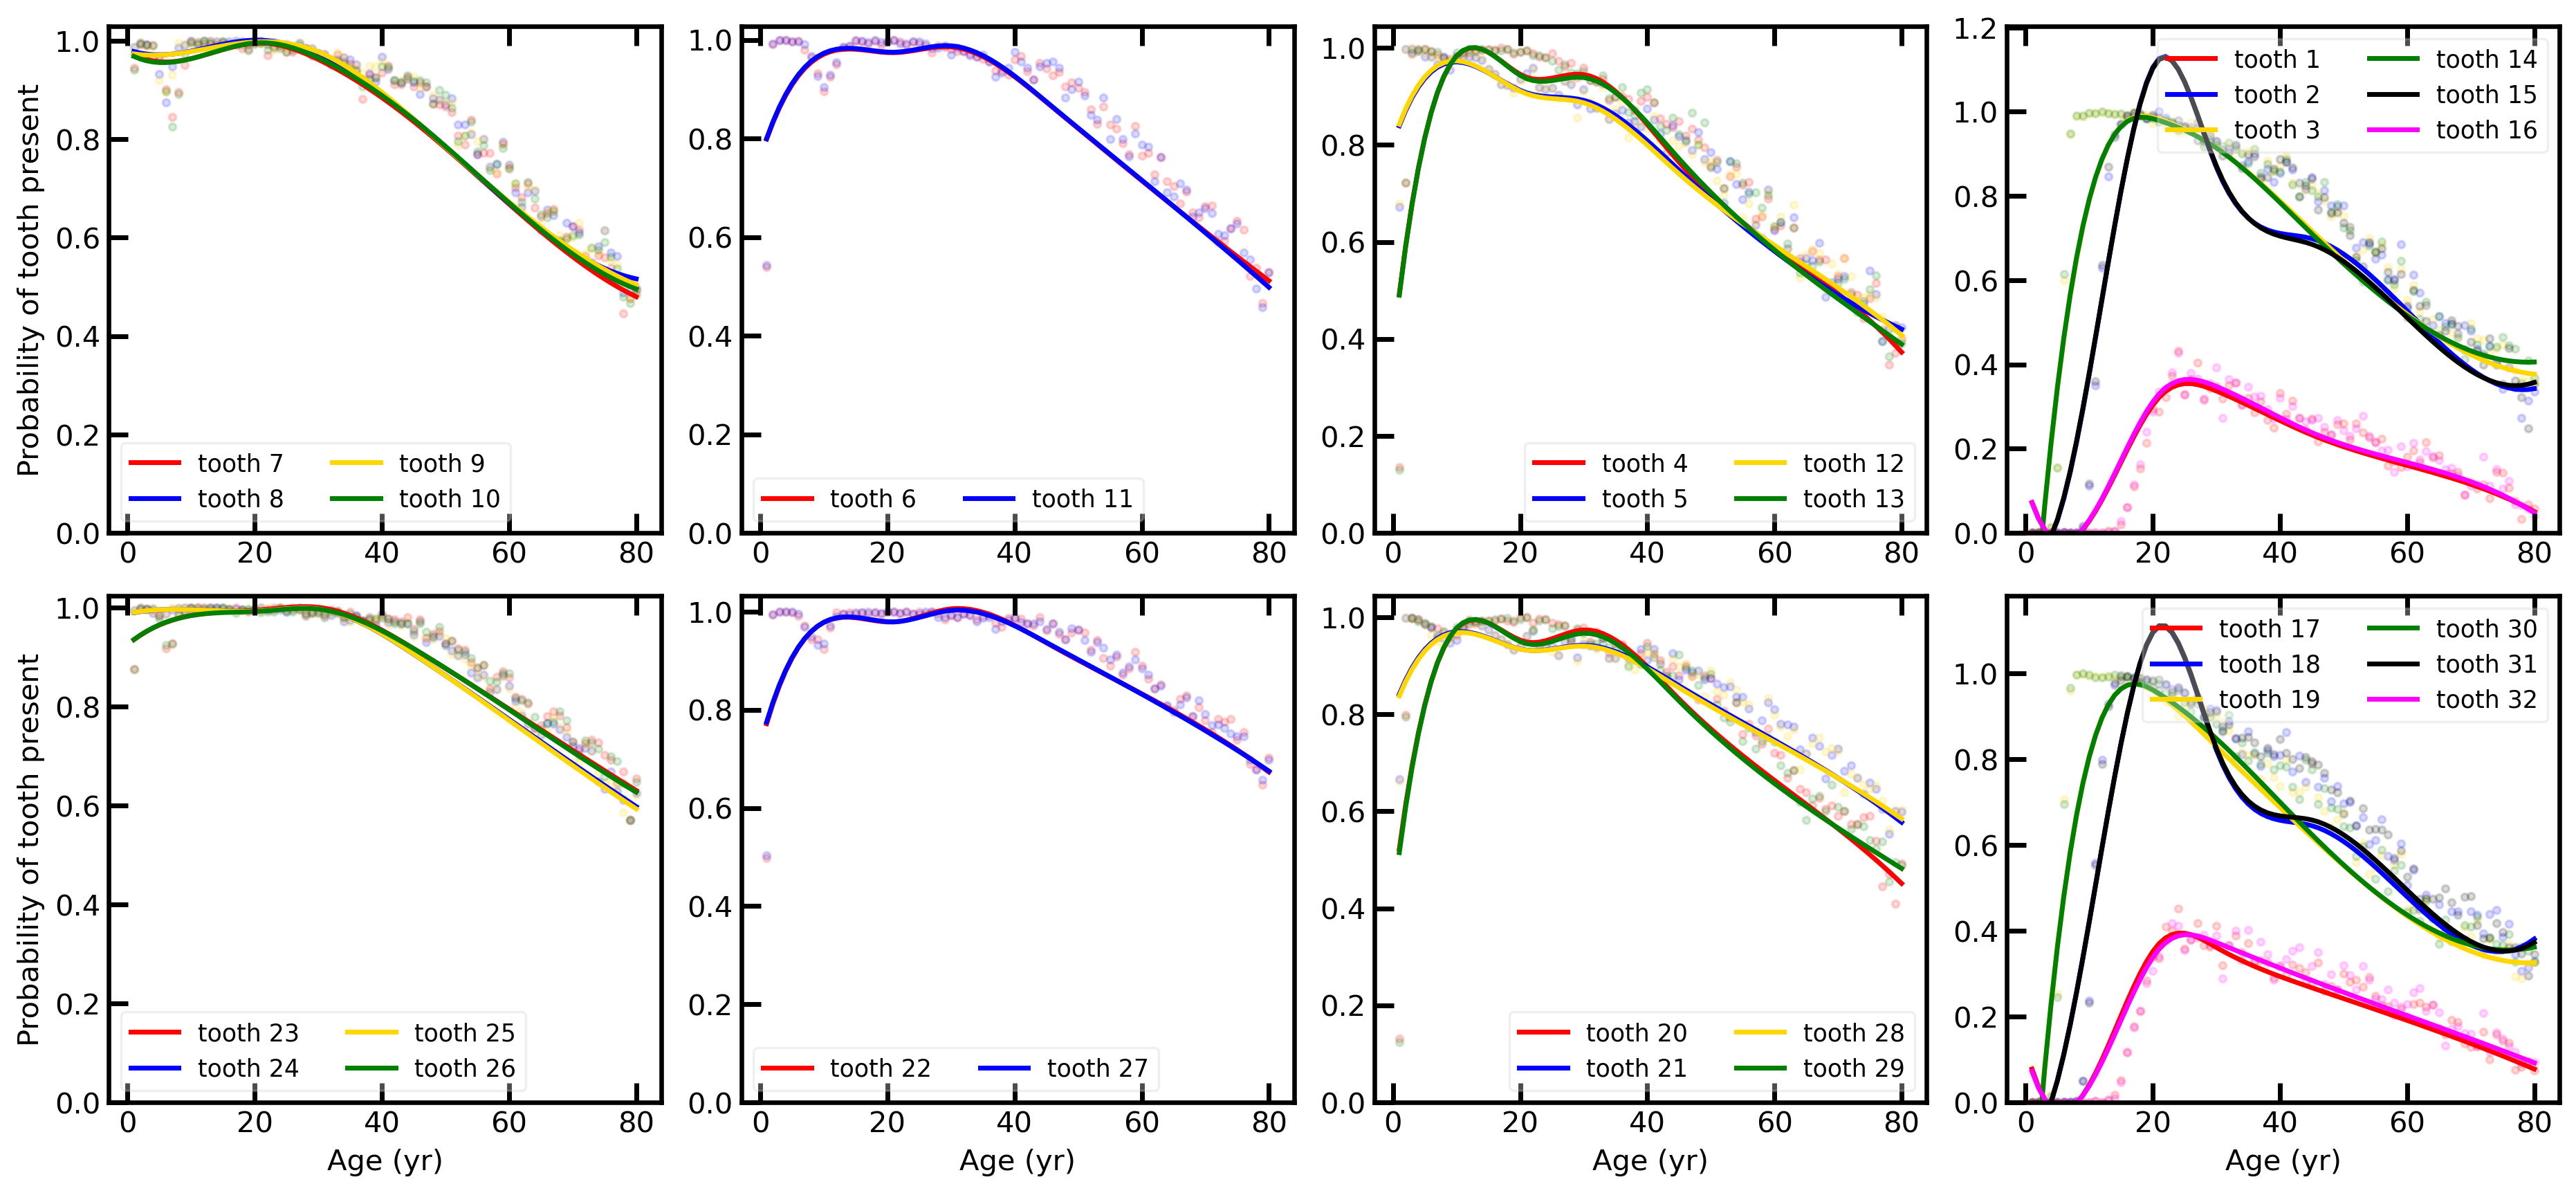

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(15,7))

#Defining indices of upper and lower teeth and type
index_up_inc = np.array([7,8,9,10])
index_up_can = np.array([6,11])
index_up_premol = np.array([4,5,12,13])
index_up_molar = np.array([1,2,3,14,15,16])

index_low_inc = np.array([23,24,25,26])
index_low_can = np.array([22,27])
index_low_premol = np.array([20,21,28,29])
index_low_molar = np.array([17,18,19,30,31,32])

indices = np.array([[index_up_inc,index_up_can,index_up_premol,index_up_molar],
                    [index_low_inc,index_low_can,index_low_premol,index_low_molar]])

colors = ["red", "blue", "gold", "green", "black", "magenta"]
        

for i in range(2):
    axs[i,0].set_ylabel("Probability of tooth present")
    for j in range(4):
        labels = ["tooth "+str(i) for i in indices[i,j]]
        for k in range(len(indices[i,j])):
            axs[i,j].plot(df_avg.age, prob[:, indices[i,j][k]-1], label=labels[k], c=colors[k])
            axs[i,j].scatter(df_avg.age, df_avg.iloc[:,indices[i,j][k]+2], alpha=0.15,
                             marker=".", c=colors[k])
        axs[i,j].set_ylim(bottom=0)
        axs[i,j].legend(ncol=2, framealpha=0.3)
        axs[1,j].set_xlabel("Age (yr)")


plt.tight_layout()

**Figure 1**: Probability of having a given tooth as a function of age. Each column represetn a different type of tooth. From left to right: Incisors, canines, premolars and molars. The top row is for the upper teeth and the bottom row for lower teeth. Circles represented the observed probabilities form the data while solid lines the Splines fit.

# Question 2 - Hosmer-Lemeshow Calibration Plot

### a)

In [12]:
def getting_deciles(cdf_array):
    """
    Get the closest indices to the deciles given an array cdf-like.
    Input:
    ------
    cdf_array: Sorted array from 0 to 1, as a cdf.
    
    Output:
    ------
    decils_ind: array with the indices closes to the deciles.
    """
    decils_probs = np.linspace(0,1,11)
    ind_dec = np.array([np.argmin(np.abs(decil-cdf_array)) for decil in decils_probs])
    return ind_dec




ages, counts = np.unique(df.age, return_counts=True)
total = counts.sum()
expected_cases = prob[:,9]*counts
sort_prob_ind = np.argsort(prob[:,9])
sort_prob = prob[sort_prob_ind]

#compute some sort of cdf.
e_cdf = np.zeros(ages.size)
e_cdf[0] = counts[sort_prob_ind[0]]/total
for i in range(1,ages.size):
    e_cdf[i] = counts[sort_prob_ind[i]]/total + e_cdf[i-1]
    
#decil indices
ind_dec = getting_deciles(e_cdf)


### b)

In [13]:
expected_prob = np.zeros(10)
observed_prob = np.zeros(10)

for i in range(10):
    ages_decil = df2.age[sort_prob_ind[ind_dec[i]:ind_dec[i+1]]]
    count_aux = 0
    for j in range(ages_decil.size):
        str_age = str(ages_decil.iloc[j])
        count_age = df.query("age == "+str_age).tooth_10_C.size
        observed_prob[i] += df.query("age == "+str_age).tooth_10_C.mean()*count_age
        expected_prob[i] += prob[sort_prob_ind[[ind_dec[i]+j]],9]*count_age
        count_aux += count_age
    observed_prob[i] /= count_aux 
    expected_prob[i] /= count_aux
        

### c)

(0.48, 1.0)

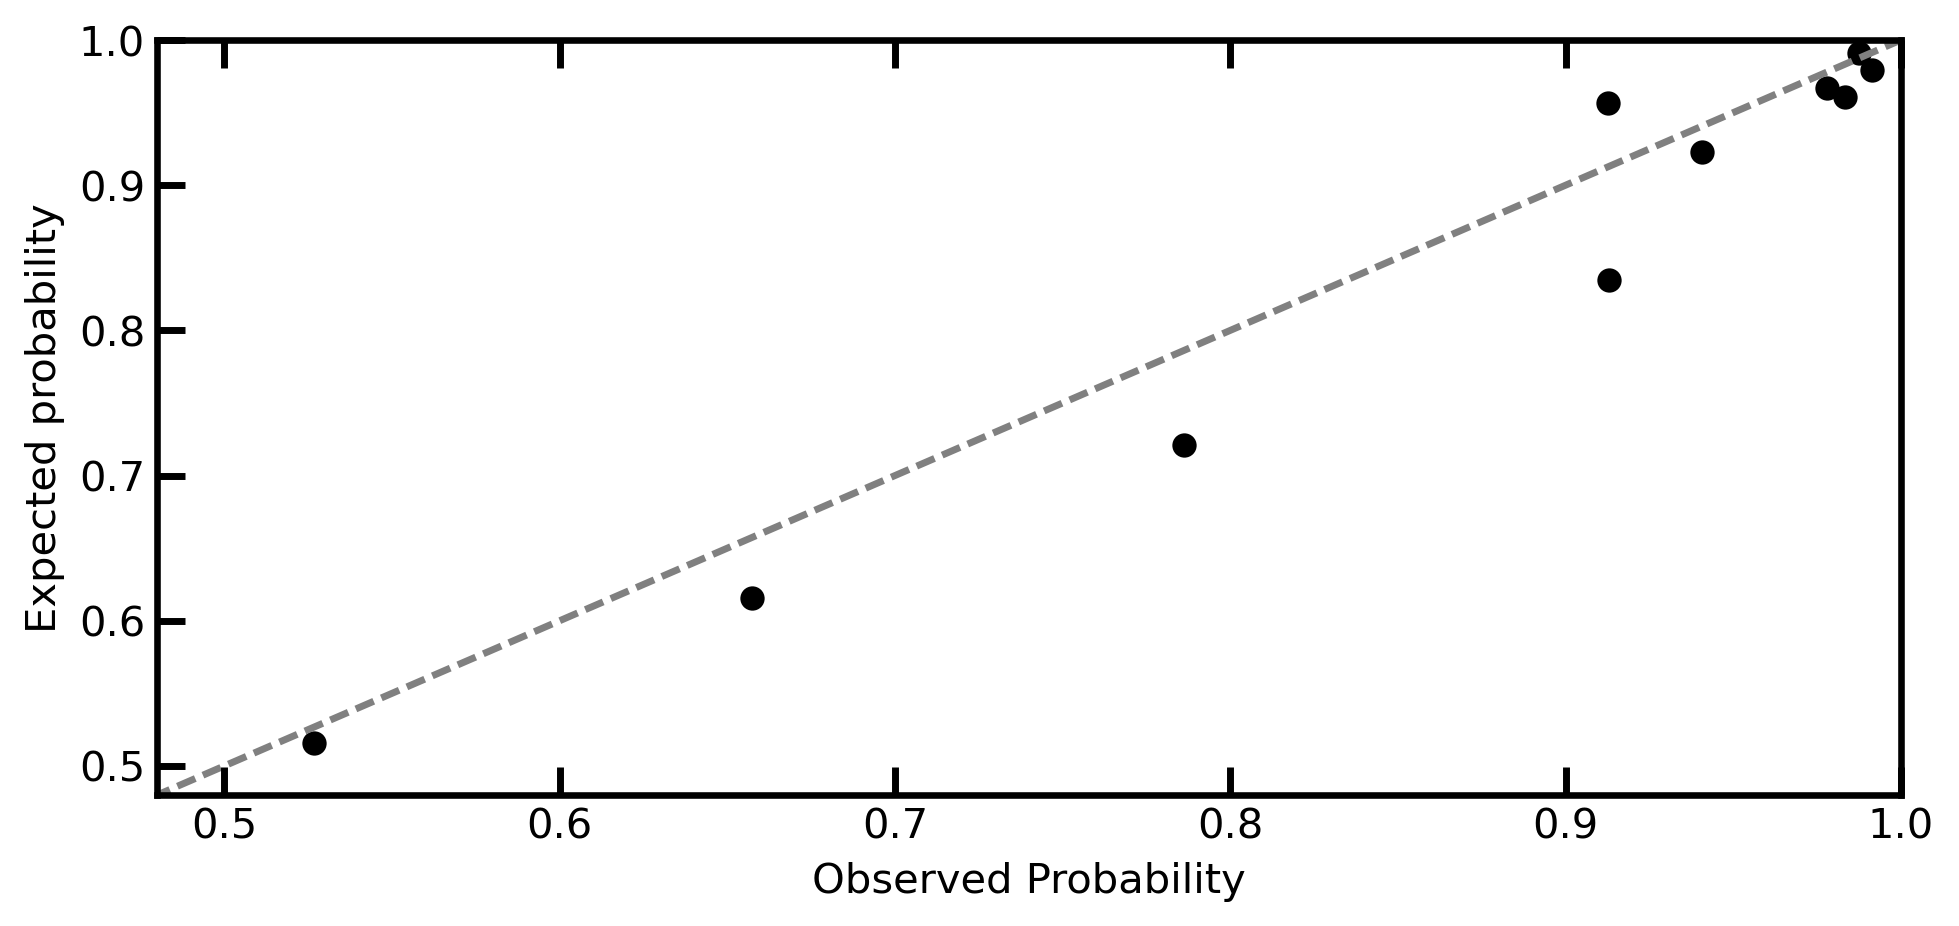

In [14]:
fig = plt.figure(figsize=(9,4))
plt.scatter(observed_prob, expected_prob, c="k")
plt.plot(np.linspace(0,1.,100),np.linspace(0,1.,100),'--', c="gray")
plt.xlabel("Observed Probability")
plt.ylabel("Expected probability")

plt.xlim([0.48,1])
plt.ylim([0.48,1])

**Figure 2:** Comparison between expected probability and observed probability for each decile group.

### d)

For intermediatiate probabilities, i.e. between 0.6 and 0.9, the observed probability is below the identity line, meaning that we are underpredicting the observed probability. The number of cases in that range with a permament tooth 10 is higher. For the one point at $P$=0.5 is right next to the identity line and the high probability point are clustered around the identitiy as well, which meand that the fit is working in both extremes of the observed range, Nevertheless, there is space for improvement for ages with intermediate probability.